datasets: (60000, 28, 28) (60000,) 0 255
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             multiple                  200960    
_________________________________________________________________
dense_76 (Dense)             multiple                  32896     
_________________________________________________________________
dense_77 (Dense)             multiple                  8256      
_________________________________________________________________
dense_78 (Dense)             multiple                  2080      
_________________________________________________________________
dense_79 (Dense)             multiple                  330       
Total params: 244,522
Trainable params: 244,522
Non-trainable params: 0
_________________________________________________________________
0 loss: 2.297055721282959
0 Evaluate Acc: 0.20282451923076922


InvalidArgumentError: slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

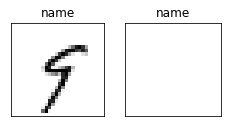

In [21]:
import  tensorflow as tf
from    tensorflow.keras import datasets, layers, optimizers, Sequential, metrics
import  datetime
from    matplotlib import pyplot as plt
import  io

def preprocess(x, y):

    x = tf.cast(x, dtype=tf.float32) / 255.
    y = tf.cast(y, dtype=tf.int32)

    return x,y


def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

def image_grid(images):
  """Return a 5x5 grid of the MNIST images as a matplotlib figure."""
  # Create a figure to contain the plot.
  figure = plt.figure(figsize=(10,10))
  for i in range(25):
    # Start next subplot.
    plt.subplot(5, 5, i + 1, title='name')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
  
  return figure



batchsz = 128
(x, y), (x_val, y_val) = datasets.mnist.load_data()
print('datasets:', x.shape, y.shape, x.min(), x.max())



db = tf.data.Dataset.from_tensor_slices((x,y))
db = db.map(preprocess).shuffle(60000).batch(batchsz).repeat(10)

ds_val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
ds_val = ds_val.map(preprocess).batch(batchsz, drop_remainder=True) 




network = Sequential([layers.Dense(256, activation='relu'),
                     layers.Dense(128, activation='relu'),
                     layers.Dense(64, activation='relu'),
                     layers.Dense(32, activation='relu'),
                     layers.Dense(10)])
network.build(input_shape=(None, 28*28))
network.summary()

optimizer = optimizers.Adam(lr=0.01)



current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/' + current_time
summary_writer = tf.summary.create_file_writer(log_dir) 

# get x from (x,y)
sample_img = next(iter(db))[0]
# get first image instance
sample_img = sample_img[0]
sample_img = tf.reshape(sample_img, [1, 28, 28, 1])
with summary_writer.as_default():
    tf.summary.image("Training sample:", sample_img, step=0)

for step, (x,y) in enumerate(db):

    with tf.GradientTape() as tape:
        # [b, 28, 28] => [b, 784]
        x = tf.reshape(x, (-1, 28*28))
        # [b, 784] => [b, 10]
        out = network(x)
        # [b] => [b, 10]
        y_onehot = tf.one_hot(y, depth=10) 
        # [b]
        loss = tf.reduce_mean(tf.losses.categorical_crossentropy(y_onehot, out, from_logits=True))

 

    grads = tape.gradient(loss, network.trainable_variables)
    optimizer.apply_gradients(zip(grads, network.trainable_variables))


    if step % 100 == 0:

        print(step, 'loss:', float(loss))
        with summary_writer.as_default(): 
            tf.summary.scalar('train-loss', float(loss), step=step) 

    # evaluate
    if step % 500 == 0:
        
        network.save_weights('weights-{}.ckpt'.format(step))
        
        total, total_correct = 0., 0

        for _, (x, y) in enumerate(ds_val):  
            # [b, 28, 28] => [b, 784]
            x = tf.reshape(x, (-1, 28*28))
            # [b, 784] => [b, 10]
            out = network(x) 
            # [b, 10] => [b] 
            pred = tf.argmax(out, axis=1) 
            pred = tf.cast(pred, dtype=tf.int32)
            # bool type 
            correct = tf.equal(pred, y)
            # bool tensor => int tensor => numpy
            total_correct += tf.reduce_sum(tf.cast(correct, dtype=tf.int32)).numpy()
            total += x.shape[0]

        print(step, 'Evaluate Acc:', total_correct/total)

        
        # print(x.shape) 
        val_images = x[:25]
        val_images = tf.reshape(val_images, [-1, 28, 28, 1])
        with summary_writer.as_default():
            tf.summary.scalar('test-acc', float(total_correct/total), step=step)
            #tf.summary.image("val-onebyone-images:", val_images, max_outputs=25, step=step)
            
            val_images = tf.reshape(val_images, [-1, 28, 28])
            figure  = image_grid(val_images)
            tf.summary.image('val-images:', plot_to_image(figure), step=step)